# **Movies Recommender System**
Student name: Colleta Kiilu

# **Executive Summary**

In order to overcome the difficulty streaming services confront in offering users individualized material, the project's goal was to create a movie recommendation system. The main problem is that general suggestions may irritate users, reduce their level of interest, and eventually result in lost sales.  This system provides personalized movie recommendations based on user ratings and preferences, improving the viewing experience and increasing user happiness.

The main objective was to build a model capable of generating the top 5 movie recommendations for a given user based on their historical ratings.  This involved three key goals:

* **Increased User Engagement:** By suggesting movies aligned with users' past viewing habits and interests, the system aims to keep viewers engaged longer and encourage return visits.
* **Maximized Recommendation Diversity:** The model strives to balance familiarity and exploration, recommending movies that match user preferences while also introducing them to new and potentially appealing content.
* **Improved Content Discoverability:** The system helps users discover a wider range of movies, including hidden gems within the platform's extensive library, thereby broadening their viewing horizons.

The project involved data collection, preprocessing, exploratory data analysis (EDA), and model development. Several models were evaluated, including SVD (Singular Value Decomposition) and KNN (K-Nearest Neighbors) based approaches.  

**Hyperparameter tuning** was also employed to optimize model performance. The tuned SVD model achieved the best results, demonstrating its ability to accurately predict user ratings and generate relevant recommendations. The final system provides personalized movie recommendations, directly addressing the core business need for enhanced user experience and engagement.

# **Business Understanding**
- Providing viewers with personalized content recommendations that suit their preferences is an essential issue for movie streaming services. This problem may cause users to become frustrated, interact less, and eventually cost the platform money.
- A movie recommendation system that makes use of user ratings and preferences can be put into place to solve this problem and greatly improve the viewing experience.
- The system can effectively recommend movies that align with users' preferences by utilizing data-driven insights, which raises the possibility of user engagement and happiness.
- The deployment of such a system has significant business advantages, such as higher conversion rates, better customer satisfaction, and improved user retention.


# **Project Objectives**
- The main objective of this project is to build a model that provides top 5 movie recommendations to a user, based on their ratings of other movies.
- Specifically, the aim of the model is to:
1. **Increase user engagement**
  - Based on users' past viewing habits and interests, the model will tailor suggestions to keep viewers engaged for longer periods and increase their likelihood of returning to the site
2. **Maximize diversity in recommendations**
  - A model that strikes a balance between familiarity and exploration so that films that suit users' preferences are recommended as well as exposing users to new suggestions.
3. **Improve content discoverability**
  - Increased user engagement by showcasing a broader selection of films, including hidden gems from its extensive library.
  


# **Importing the relevant libraries**

In [12]:
pip install surprise

In [13]:
import requests
import zipfile
import io
import os
import joblib

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from wordcloud import WordCloud

from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors

from surprise import Dataset, Reader, accuracy, dump
from surprise import SVD, SVDpp, KNNBasic, KNNBaseline, KNNWithMeans
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split

import warnings
warnings.filterwarnings('ignore')

# **Data Understanding**
- This section will help to explore the data to understand its size, features/columns, data types, statistical summary, as well as deal with missing values and duplicates.
- The data was sourced from the popular [MovieLens](https://grouplens.org/datasets/movielens/latest/) dataset from the GroupLens research lab at the University of Minnesota.

## **Loading the Datasets**

In [14]:
# Unzip ml-latest-small.zip

!unzip /content/ml-latest-small.zip


Archive:  /content/ml-latest-small.zip
replace ml-latest-small/links.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ml-latest-small/tags.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ml-latest-small/ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ml-latest-small/README.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ml-latest-small/movies.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [15]:
movies_df = pd.read_csv('ml-latest-small/movies.csv')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [16]:
ratings_df = pd.read_csv('ml-latest-small/ratings.csv')
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [17]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [18]:
links_df = pd.read_csv('ml-latest-small/links.csv')
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [19]:
tags_df = pd.read_csv('ml-latest-small/tags.csv')
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


## **Merging the data**

In [20]:
merged_df = pd.merge(ratings_df, movies_df, on = "movieId", how = "left")
merged_df = pd.merge(merged_df,tags_df, on = "movieId", how = "left", suffixes = ("rater", "tag"))
merged_df = pd.merge(merged_df,links_df, on = "movieId", how = "left")

- The function below will perform the data understanding processes on the merged dataset.

In [21]:
def analyze_dataset(df):
    print("Shape of the dataset:", df.shape, '\n')

    # Dataset shape
    print("*"*50)

    # Missing values
    print("Null Values percentage:", df.isnull().mean()*100, '\n')
    print("*"*50)

    # Duplicate values
    print("Number of duplicates:", len(df.loc[df.duplicated()]), '\n')
    print("*"*50)

    # # Target value count
    # print("Count of each value of target:")
    # print(gilead['DiagPeriodL90D'].value_counts(normalize=True), '\n')
    # print("*"*39)

    # Unique values
    print("The unique values per column are:")
    print(df.nunique().sort_values(ascending=False), '\n')
    print("*"*50)

    # Dataset information
    print("Information about the dataset:")
    print(df.info())

    # Distribution
    display(df.describe().T)
    # categorical columns
    display(df.select_dtypes(include=['object']).describe().T)

In [22]:
analyze_dataset(merged_df)

Shape of the dataset: (285762, 11) 

**************************************************
Null Values percentage: userIdrater        0.000000
movieId            0.000000
rating             0.000000
timestamprater     0.000000
title              0.000000
genres             0.000000
userIdtag         18.389079
tag               18.389079
timestamptag      18.389079
imdbId             0.000000
tmdbId             0.004549
dtype: float64 

**************************************************
Number of duplicates: 0 

**************************************************
The unique values per column are:
timestamprater    85043
movieId            9724
imdbId             9724
title              9719
tmdbId             9715
timestamptag       3392
tag                1584
genres              951
userIdrater         610
userIdtag            56
rating               10
dtype: int64 

**************************************************
Information about the dataset:
<class 'pandas.core.frame.DataFrame'>
Ra

,count,mean,std,min,25%,50%,75%,max
userIdrater,285762.0,3.138943e+02,1.794514e+02,1.000000e+00,1.600000e+02,3.140000e+02,4.650000e+02,6.100000e+02
movieId,285762.0,1.492739e+04,3.140337e+04,1.000000e+00,2.960000e+02,1.721000e+03,5.673000e+03,1.936090e+05
rating,285762.0,3.841270e+00,1.020798e+00,5.000000e-01,3.000000e+00,4.000000e+00,4.500000e+00,5.000000e+00
timestamprater,285762.0,1.214707e+09,2.233730e+08,8.281246e+08,1.019133e+09,1.211377e+09,1.445346e+09,1.537799e+09
userIdtag,233213.0,4.706836e+02,1.533296e+02,2.000000e+00,4.240000e+02,4.770000e+02,5.990000e+02,6.100000e+02
timestamptag,233213.0,1.384774e+09,1.534621e+08,1.137179e+09,1.242494e+09,1.457901e+09,1.498457e+09,1.537099e+09
imdbId,285762.0,2.956129e+05,5.150267e+05,4.170000e+02,1.098300e+05,1.125730e+05,2.415270e+05,8.391976e+06
tmdbId,285749.0,1.279662e+04,4.348058e+04,2.000000e+00,4.890000e+02,6.800000e+02,8.963000e+03,5.256620e+05


,count,unique,top,freq
title,285762,9719,Pulp Fiction (1994),55567
genres,285762,951,Comedy|Crime|Drama|Thriller,56864
tag,233213,1584,sci-fi,2527


- The data now has 285,762 rows/records and 11 columns. The features are:

 - **userIdrater**: user ID of the rater.
 - **movieId**: ID of the movie being rated as per MovieLens
 - **rating**: rating given by the user to the movie.
 - **timestamprater**: timestamp of when the rating was given.
 - **title**: title of the movie.
 - **genres**: genres associated with the movie.
 - **userIdtag**: user ID of the tagger.
 - **tag**: tag associated with the movie.
 - **Timestamptag**: timestamp of when the tag was assigned
 - **imdbId**: ID of the movie being rated as per IMDB
 - **tmdbId**: ID of the movie being rated as per The MovieDB

- Data types are float, int, object.
- There are no duplicate values.
- `userIdtag`, `tag`, and `timestamptag` columns have rows with missing values (18.38% of the data) while `tmdbId` has 0.0046%.

## **Dropping Null Values**
- Rows with missing values will be dropped, and the dataset size will still be sufficient for the project.

In [23]:
merged_clean = merged_df.dropna()
merged_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 233213 entries, 0 to 285760
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   userIdrater     233213 non-null  int64  
 1   movieId         233213 non-null  int64  
 2   rating          233213 non-null  float64
 3   timestamprater  233213 non-null  int64  
 4   title           233213 non-null  object 
 5   genres          233213 non-null  object 
 6   userIdtag       233213 non-null  float64
 7   tag             233213 non-null  object 
 8   timestamptag    233213 non-null  float64
 9   imdbId          233213 non-null  int64  
 10  tmdbId          233213 non-null  float64
dtypes: float64(4), int64(4), object(3)
memory usage: 21.4+ MB


- 233,213 records are now left.
- Next, timestamp data was converted to datetime format for better analysis.


In [24]:
# Convert timestamps to datetime
merged_clean["timestamprater"] = pd.to_datetime(merged_clean["timestamprater"], unit='s')
merged_clean["timestamptag"] = pd.to_datetime(merged_clean["timestamptag"], unit='s')

merged_clean.info()


<class 'pandas.core.frame.DataFrame'>
Index: 233213 entries, 0 to 285760
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   userIdrater     233213 non-null  int64         
 1   movieId         233213 non-null  int64         
 2   rating          233213 non-null  float64       
 3   timestamprater  233213 non-null  datetime64[ns]
 4   title           233213 non-null  object        
 5   genres          233213 non-null  object        
 6   userIdtag       233213 non-null  float64       
 7   tag             233213 non-null  object        
 8   timestamptag    233213 non-null  datetime64[ns]
 9   imdbId          233213 non-null  int64         
 10  tmdbId          233213 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(3), object(3)
memory usage: 21.4+ MB


In [25]:
merged_clean.head()

,userIdrater,movieId,rating,timestamprater,title,genres,userIdtag,tag,timestamptag,imdbId,tmdbId
0,1,1,4.0,2000-07-30 18:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336.0,pixar,2006-02-04 09:36:04,114709,862.0
1,1,1,4.0,2000-07-30 18:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,474.0,pixar,2006-01-14 02:47:05,114709,862.0
2,1,1,4.0,2000-07-30 18:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,567.0,fun,2018-05-02 18:33:33,114709,862.0
3,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men (1995),Comedy|Romance,289.0,moldy,2006-03-27 02:01:00,113228,15602.0
4,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men (1995),Comedy|Romance,289.0,old,2006-03-27 02:01:00,113228,15602.0


# **Exploratory Data Analysis (EDA)**

## **1. No. of Users vs No. of Movies**

Unique users: 610
Unique movies: 1554


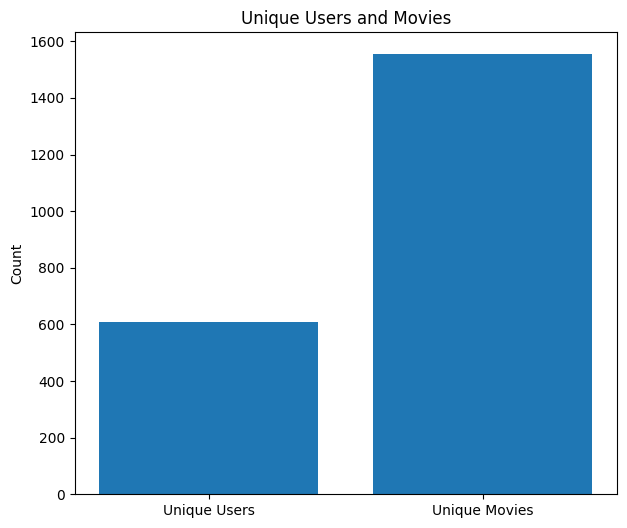

In [26]:
num_users = merged_clean["userIdrater"].nunique()
print("Unique users:", num_users)
num_movies = merged_clean["movieId"].nunique()
print("Unique movies:", num_movies)

# Create a bar plot for unique users and items
plt.figure(figsize=(7, 6))
plt.bar(["Unique Users", "Unique Movies"], [num_users, num_movies])
plt.ylabel("Count")
plt.title("Unique Users and Movies")
plt.show()

- There are 610 unique users and 1,554 unique movies.

## **2. Ratings**

### **a. Distribution**

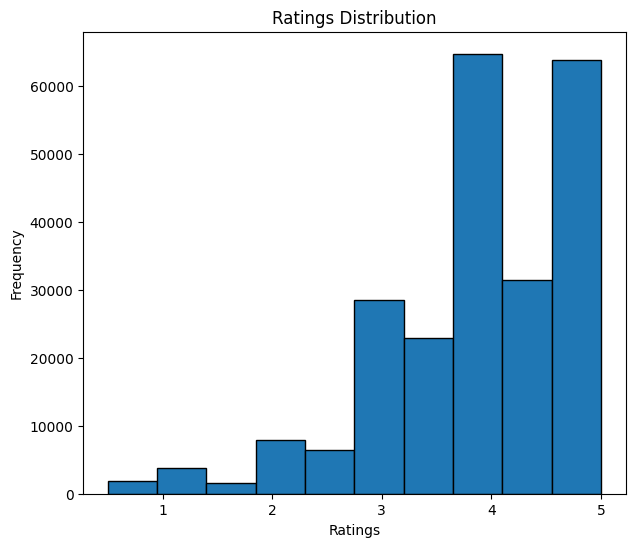

In [27]:
plt.figure(figsize=(7,6))
plt.hist(merged_clean["rating"], bins=10, edgecolor="black")
plt.xlabel("Ratings")
plt.ylabel("Frequency")
plt.title("Ratings Distribution")
plt.show()

### **c. Average number of ratings per user**

Average number of ratings per user: 382.32


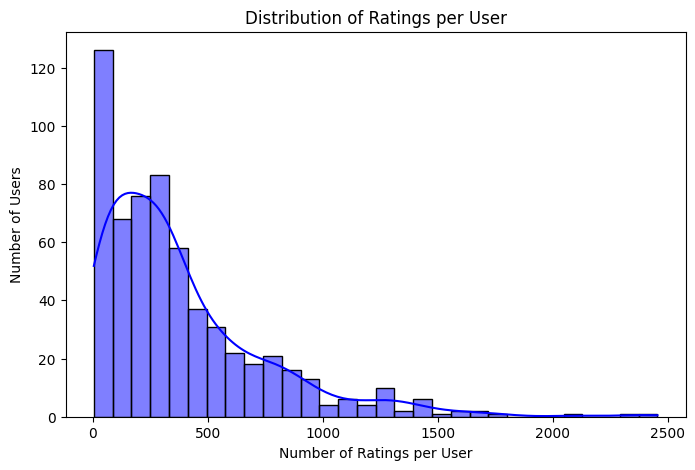

In [28]:
ratings_per_user = merged_clean.groupby("userIdrater")["rating"].count()
avg_ratings_per_user = ratings_per_user.mean()

print(f"Average number of ratings per user: {avg_ratings_per_user:.2f}")

# Visualizing the distribution of ratings per user
plt.figure(figsize=(8, 5))
sns.histplot(ratings_per_user, bins=30, kde=True, color="blue")
plt.xlabel("Number of Ratings per User")
plt.ylabel("Number of Users")
plt.title("Distribution of Ratings per User");

- Most users gave a rating of 4 and 5.
- The average number of ratings per user is 382.32.

In [29]:
top_users = ratings_per_user.sort_values(ascending=False).head(10)
print("Top 10 users with the most ratings:\n", top_users)
print("--"*50)

bottom_users = ratings_per_user.sort_values(ascending=True).head(10)
print("Bottom 10 users with the least ratings:\n", bottom_users)
print("--"*50)

# user ratings by percentile
percentiles = ratings_per_user.describe(percentiles=[.25, .50, .75, .90, .95, .99])
print("\nUser Ratings Percentiles:\n", percentiles)

Top 10 users with the most ratings:
 userIdrater
474    2455
414    2343
599    2100
68     1791
610    1701
274    1665
249    1635
448    1575
380    1536
305    1460
Name: rating, dtype: int64
----------------------------------------------------------------------------------------------------
Bottom 10 users with the least ratings:
 userIdrater
175     5
578     6
207     8
499     9
406    10
442    11
576    12
545    12
158    12
147    12
Name: rating, dtype: int64
----------------------------------------------------------------------------------------------------

User Ratings Percentiles:
 count     610.000000
mean      382.316393
std       365.395411
min         5.000000
25%       106.500000
50%       280.000000
75%       525.000000
90%       854.200000
95%      1146.150000
99%      1629.600000
max      2455.000000
Name: rating, dtype: float64


**1. Users**
- The most active user (userIdrater = 474) rated 2,455 movies.
- The second most active (userIdrater = 414) rated 2,343 movies.
- Even the 10th most active user rated 1,460 movies.

**2. Average and Distribution of Ratings per User**
- The mean is 382.3, while the median (50th percentile) =is 280. It shows that most users rated fewer movies than the mean suggests.
- The standard deviation of 365.4 is an indication of a large variation in how many movies users rate.

**3. User rating activity**
- The 25th percentile (106.5 ratings) and 75th percentile (525 ratings) show that many users rate relatively few movies.
- The 95th percentile (1,146 ratings) and 99th percentile (1,629 ratings) confirm that a small group of users contributes a huge number of ratings.

These observations and the histogram point to highly skewed data where the most active user rated 2,500 movies and the least active user rated 5 movies. It will be important to normalize the ratings to minimize the influence of the active users.

## **3. Categorical Columns**

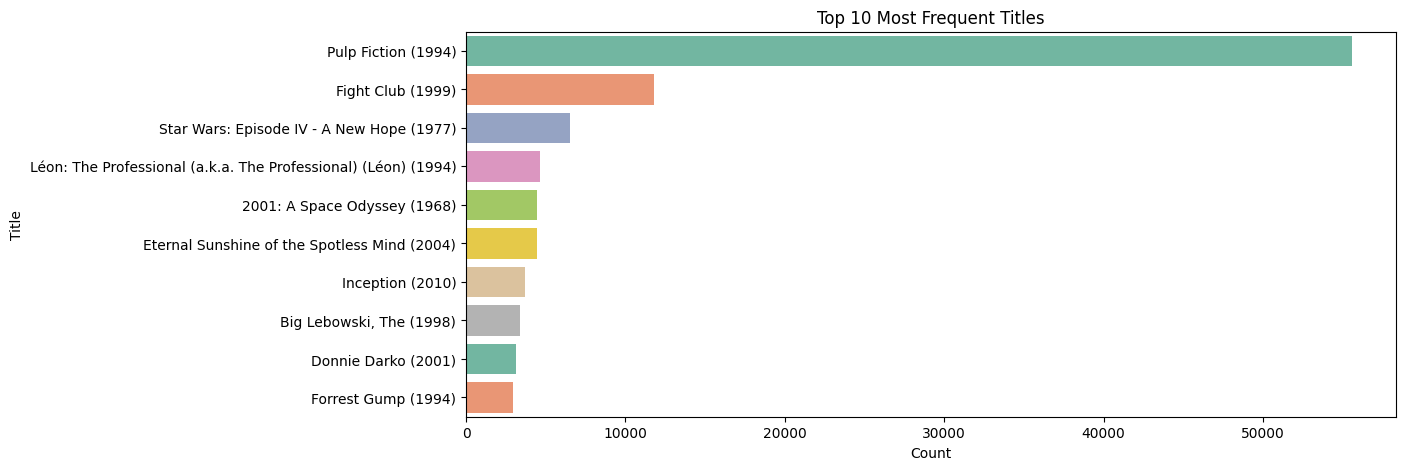

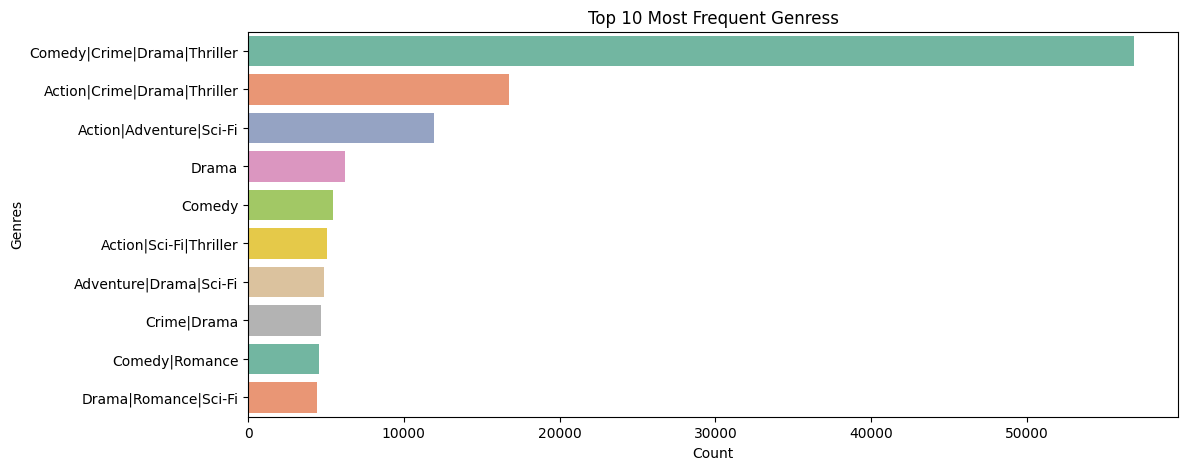

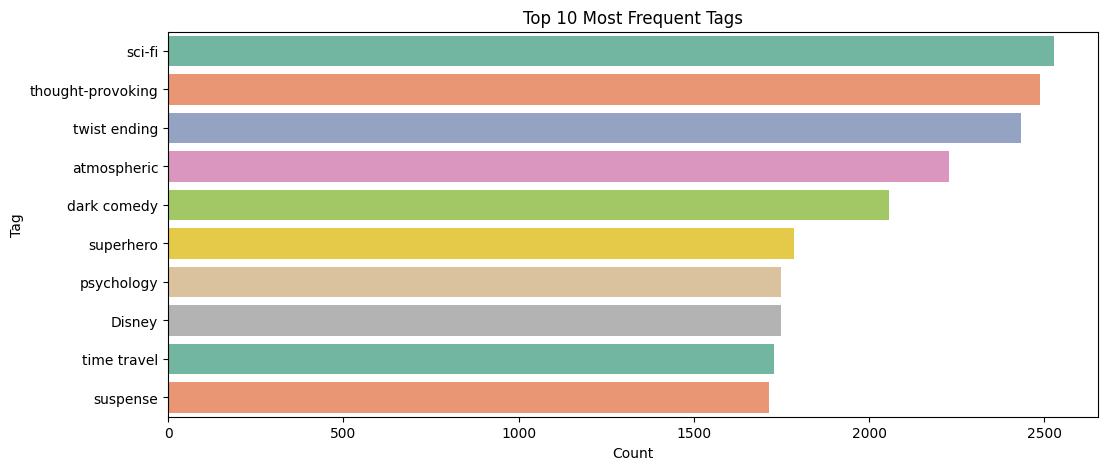

In [30]:
cat_cols = ["title", "genres", "tag"]
for col in cat_cols:
    plt.figure(figsize=(12, 5))
    sns.barplot(y=merged_clean[col].value_counts().head(10).index,
                x=merged_clean[col].value_counts().head(10).values,
                palette="Set2")
    plt.title(f"Top 10 Most Frequent {col.capitalize()}s")
    plt.xlabel("Count")
    plt.ylabel(col.capitalize())
    plt.show()

- **Pulp Fiction (1994)** was the most popular movie, going by the number of times it was rated in the dataset.
- **Commedy/Crime/Drama/Thriller** was the most frequently reviewed genre.
- **Sci-fi, thought-provoking and twist ending** topped as the most frequent tags.
- A wordcloud can represent the tags popularity better.

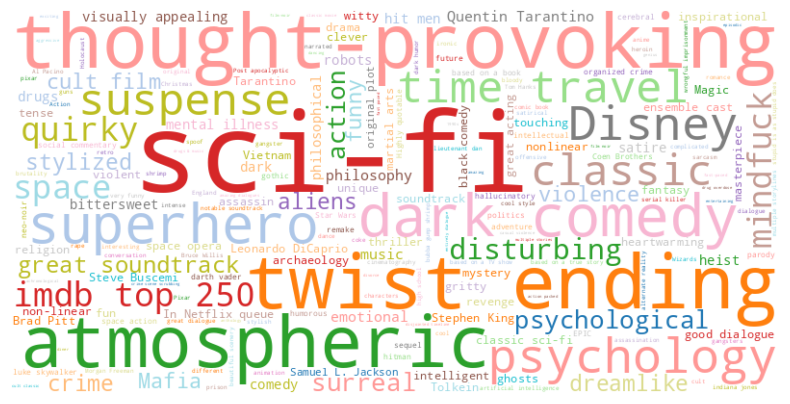

In [31]:
# tag frequency
tag_counts = merged_clean['tag'].value_counts()

# a dictionary of tag frequencies
tag_frequencies = {tag: count for tag, count in tag_counts.items()}

# WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap="tab20").generate_from_frequencies(tag_frequencies)

plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout();

### **a. Top 10 Highest Rated Movies**

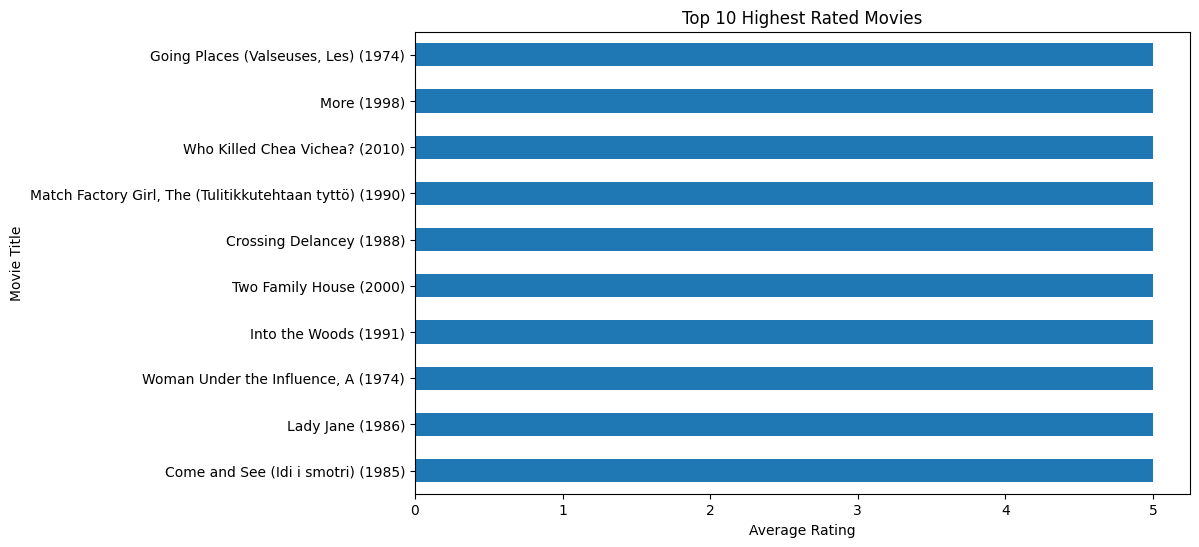

In [32]:
top_rated_movies = merged_clean.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
top_rated_movies.plot(kind='barh')
plt.title('Top 10 Highest Rated Movies')
plt.xlabel('Average Rating')
plt.ylabel('Movie Title');

### **b. Bottom 10 Lowest Rated Movies**

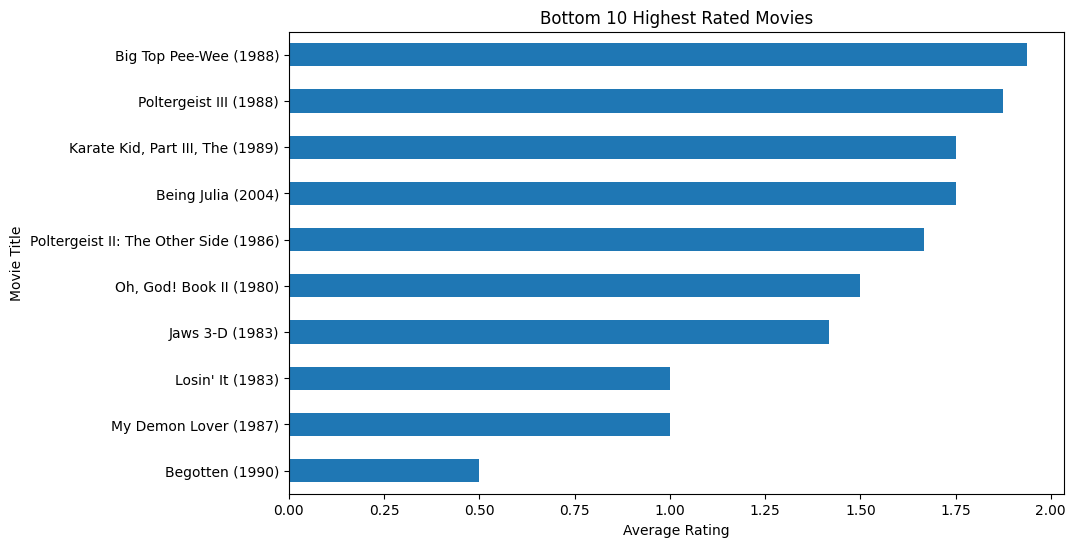

In [33]:
bottom_rated_movies = merged_clean.groupby('title')['rating'].mean().sort_values(ascending=True).head(10)
plt.figure(figsize=(10, 6))
bottom_rated_movies.plot(kind='barh')
plt.title('Bottom 10 Highest Rated Movies')
plt.xlabel('Average Rating')
plt.ylabel('Movie Title');

### **c. Top 10 Most Common Genres**

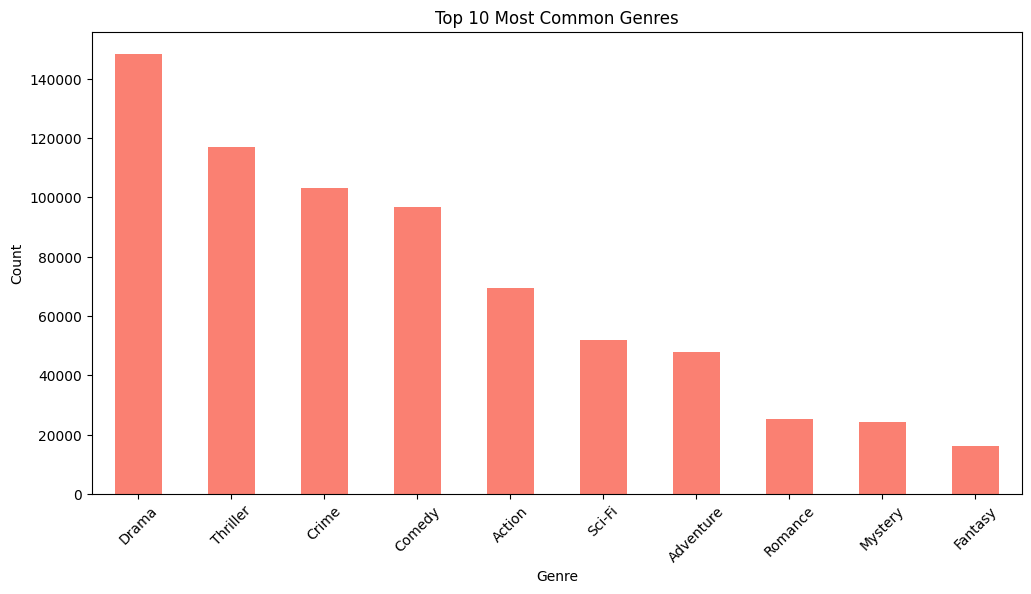

In [34]:
genre_counts_top = merged_clean['genres'].str.split('|', expand=True).stack().value_counts()
plt.figure(figsize=(12, 6))
genre_counts_top.head(10).plot(kind='bar', color='salmon')
plt.title('Top 10 Most Common Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### **d. Bottom 10 Least Common Genres**

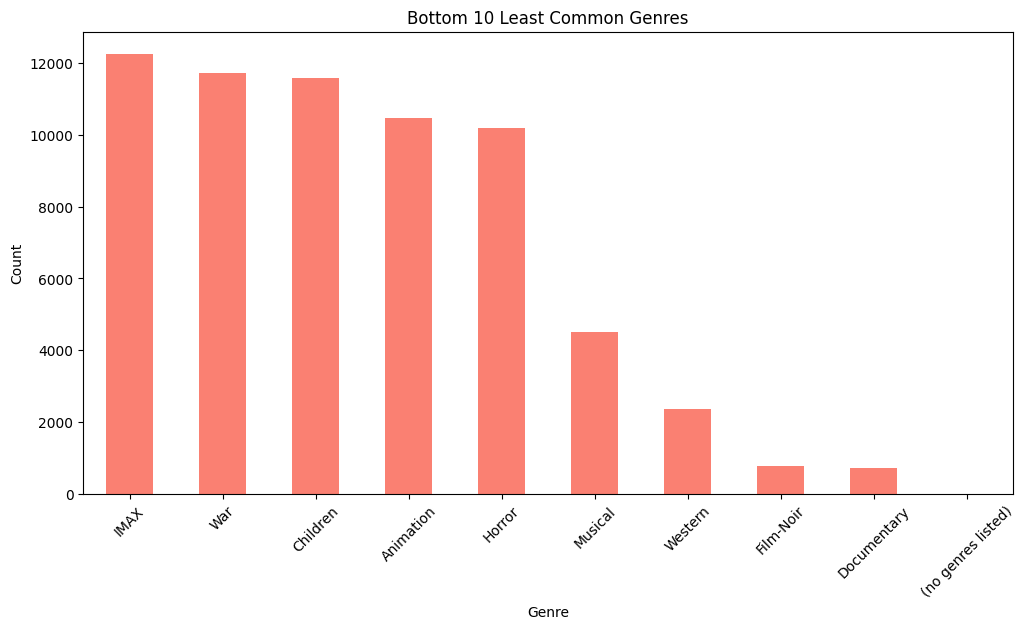

In [35]:
genre_counts_bottom = merged_clean['genres'].str.split('|', expand=True).stack().value_counts()
plt.figure(figsize=(12, 6))
genre_counts_bottom.tail(10).plot(kind='bar', color='salmon')
plt.title('Bottom 10 Least Common Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

- The top rated movies all had a rating of 5.
- On genres, **Drama**, **Thriller** and **Crime** were the most common in the dataset.
- **Western, Film-noir and Documentary** tailed the list.

### **e. Movies with Highest Average Ratings**

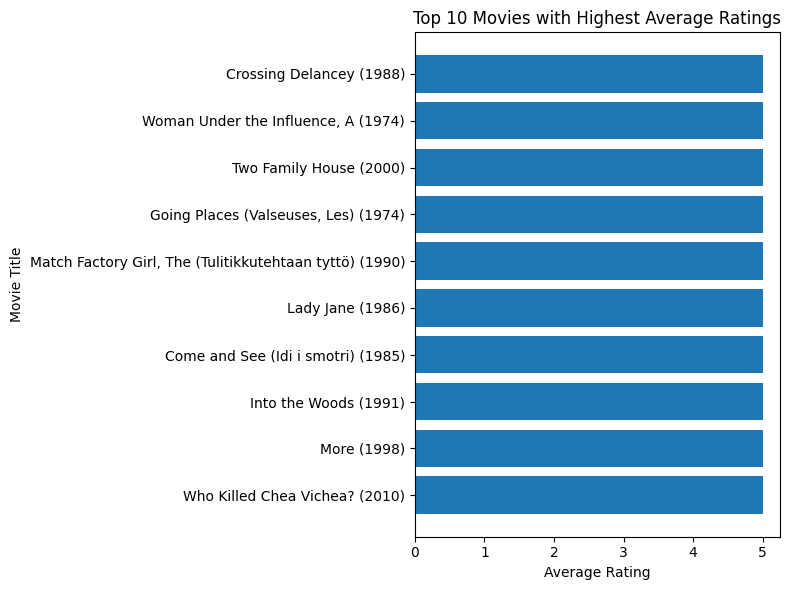

In [36]:
# Calculate the average rating for each movie
average_ratings = merged_clean.groupby(['movieId', 'title'])['rating'].mean().reset_index()

# Sort the movies by average rating in descending order
sorted_movies = average_ratings.sort_values(by='rating', ascending=False)

# Select the top movies with highest average ratings
top_movies = sorted_movies.head(10)

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.barh(top_movies['title'], top_movies['rating'])
plt.xlabel('Average Rating')
plt.ylabel('Movie Title')
plt.title('Top 10 Movies with Highest Average Ratings')
plt.gca().invert_yaxis()  # highest rating at the top
plt.tight_layout();

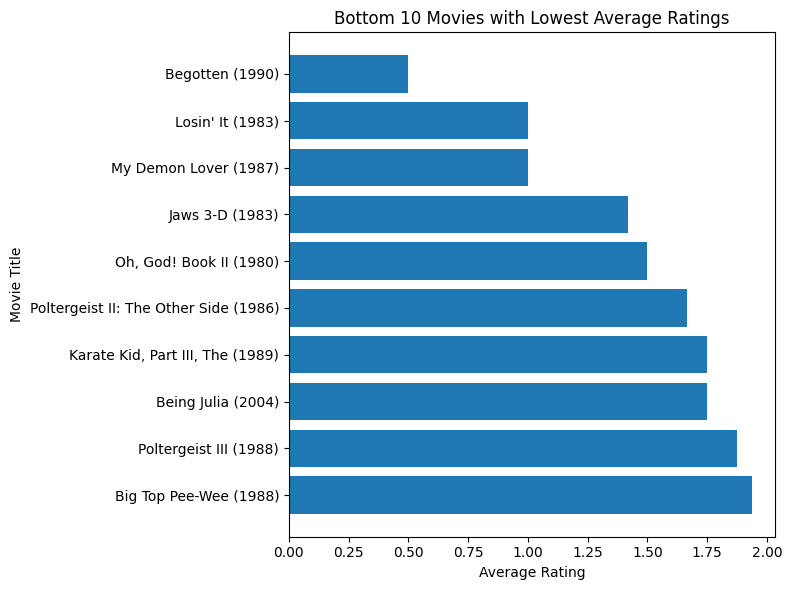

In [37]:
sorted_movies = average_ratings.sort_values(by='rating', ascending=True)
bottom_movies = sorted_movies.head(10)

plt.figure(figsize=(8, 6))
plt.barh(bottom_movies['title'], bottom_movies['rating'])
plt.xlabel('Average Rating')
plt.ylabel('Movie Title')
plt.title('Bottom 10 Movies with Lowest Average Ratings')
plt.gca().invert_yaxis()  # lowest rating at the top
plt.tight_layout();

## **4. Time-based Analysis**

In [38]:
print("Most recent timestamprater:", merged_clean['timestamprater'].max())
print("Oldest timestamprater:", merged_clean['timestamprater'].min())
print("Most recent timestamptag:", merged_clean['timestamptag'].max())
print("Oldest timestamptag:", merged_clean['timestamptag'].min())

Most recent timestamprater: 2018-09-24 14:27:30
Oldest timestamprater: 1996-03-29 18:36:55
Most recent timestamptag: 2018-09-16 11:50:03
Oldest timestamptag: 2006-01-13 19:09:12


- The timestamp features reveal that the data ranges from March 1996 to September 2018.

### **Correlation between the year and its average rating**

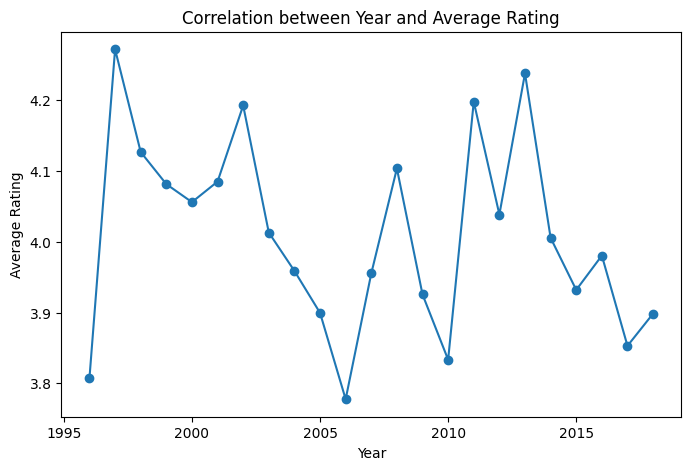

In [39]:
# Extract the year from the 'timestamprater' column
merged_clean['year'] = merged_clean['timestamprater'].dt.year

# Group by year and calculate the average rating for each year
yearly_avg_ratings = merged_clean.groupby('year')['rating'].mean()

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(yearly_avg_ratings.index, yearly_avg_ratings.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.title('Correlation between Year and Average Rating');

- Highest movie ratings were made in 1997 while the lowest ratings were in 2006.

## **5. Data Sparsity**
- Data sparsity occurs when a dataset has a large number of missing values, particularly in user-item interaction matrices.
- Luckily, Collaborative filtering inherently handles sparsity. The dataset will not need to have the missing data imputed/filled.
- However, extremely sparse data might benefit from dimensionality reduction techniques (SVD does this).

In [40]:
# check sparsity just for knowledge
total_possible_ratings = num_users * num_movies
actual_ratings = merged_clean.shape[0]

# Calculate missing ratings and sparsity
missing_ratings = total_possible_ratings - actual_ratings
sparsity = (missing_ratings / total_possible_ratings) * 100

print(f"Total possible ratings: {total_possible_ratings}")
print(f"Actual ratings: {actual_ratings}")
print(f"Sparsity of the data: {sparsity:.2f}%")

Total possible ratings: 947940
Actual ratings: 233213
Sparsity of the data: 75.40%


- The dataset is highly sparse; 75.4% of the ratings are missing.
- The model will struggle to make accurate recommendations if not dealt with.

# **Modeling**

## **1. Data Preprocessing**
-  The final model is expected to provide top 5 movie recommendations to a user, based on their ratings of other movies. Based on this, the most appropriate columns will be `userIdrater`, `movieId`, `rating`. Other columns will be excluded from the modeling dataset.

### **a. Instantiating  reader and data**

In [41]:
merged_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 233213 entries, 0 to 285760
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   userIdrater     233213 non-null  int64         
 1   movieId         233213 non-null  int64         
 2   rating          233213 non-null  float64       
 3   timestamprater  233213 non-null  datetime64[ns]
 4   title           233213 non-null  object        
 5   genres          233213 non-null  object        
 6   userIdtag       233213 non-null  float64       
 7   tag             233213 non-null  object        
 8   timestamptag    233213 non-null  datetime64[ns]
 9   imdbId          233213 non-null  int64         
 10  tmdbId          233213 non-null  float64       
 11  year            233213 non-null  int32         
dtypes: datetime64[ns](2), float64(3), int32(1), int64(3), object(3)
memory usage: 30.3+ MB


In [42]:
reader = Reader(rating_scale=(0, 5))

data = Dataset.load_from_df(merged_clean[['userIdrater', 'movieId', 'rating']], reader) # filter only the required columns

### **b. Split into training and testing sets**

In [43]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

## **Baseline Model - Basic SVD with no parameters**

In [44]:
print("Training SVD Baseline:")
svd = SVD(random_state=42)
svd.fit(train)

# Evaluate SVD
predictions_svd = svd.test(test)
rmse_svd = accuracy.rmse(predictions_svd)
mae_svd = accuracy.mae(predictions_svd)

print("\nEvaluate SVD Baseline:")
print(f"SVD RMSE: {rmse_svd:.4f}")
print(f"SVD MAE: {mae_svd:.4f}")

Training SVD Baseline:
RMSE: 0.3834
MAE:  0.2346

Evaluate SVD Baseline:
SVD RMSE: 0.3834
SVD MAE: 0.2346


**Evaluation**
- A low RMSE of 0.3834 on both training and predictions indicates that the predicted ratings are fairly accurate as they deviate from actual ratings by approximately 0.38.
- The low MAE of 0.2346 is evidence of good performance with less difference between the predicted and actual ratings.

## **Model 2: KNNBasic**

In [45]:
print("Training KNNBaseline\n")
sim_options = {'name': 'cosine', 'user_based': False}
knn_basic = KNNBasic(sim_options=sim_options, random_state=42, k=20)
knn_basic.fit(train)

# Evaluate KNNBasic
predictions_knn_basic = knn_basic.test(test)
rmse_knn_basic = accuracy.rmse(predictions_knn_basic)
mae_knn_basic = accuracy.mae(predictions_knn_basic)

print("\nEvaluate KNNBasic")
print(f"KNNBasic RMSE: {rmse_knn_basic:.4f}")
print(f"KNNBasic MAE: {mae_knn_basic:.4f}")

Training KNNBaseline

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5274
MAE:  0.2951

Evaluate KNNBasic
KNNBasic RMSE: 0.5274
KNNBasic MAE: 0.2951


**Evaluation**
- The RMSE of 0.5274 on both training and predictions indicates that the predicted ratings deviate from actual ratings by approximately 0.53.
- The MAE of 0.2951 is stil quite low, evidence of good performance with little difference between the predicted and actual ratings.

## **Model 3: KNNWithMeans**

In [46]:
print("Training KNNWithMeans\n")
sim_options = {'name': 'cosine', 'user_based': False}
knn_means = KNNWithMeans(sim_options=sim_options, random_state=42)
knn_means.fit(train)

# Evaluate KNNWithMeans
predictions_knn_means = knn_means.test(test)
rmse_knn_means = accuracy.rmse(predictions_knn_means)
mae_knn_means = accuracy.mae(predictions_knn_means)

print("\nEvaluate KNNWithMeans")
print(f"KNNWithMeans RMSE: {rmse_knn_means:.4f}")
print(f"KNNWithMeans MAE: {mae_knn_means:.4f}")


Training KNNWithMeans

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5251
MAE:  0.3176

Evaluate KNNWithMeans
KNNWithMeans RMSE: 0.5251
KNNWithMeans MAE: 0.3176


**Evaluation**
- KNNWithMeans model performs similarly to KNNBasic where RMSE is 0.52 and MAE is 0.32, both slightly different from KNNBasic.

In [47]:
# evaluation results
evaluation_results = {
    "Model": ["SVD Baseline", "KNNBasic", "KNNWithMeans"],
    "RMSE": [0.3834, 0.5274, 0.5251],
    "MAE": [0.2346, 0.2951, 0.3176]
}

# evaluation results DataFrame
df_results = pd.DataFrame(evaluation_results)

df_results

,Model,RMSE,MAE
0,SVD Baseline,0.3834,0.2346
1,KNNBasic,0.5274,0.2951
2,KNNWithMeans,0.5251,0.3176


## **Model 4: Tuned SVD**
- So far, the Baseline Singular Value Decomposition (SVD) model performs the best.
-  Hyperparameter tuning using GridSearchCV may improve the results.

In [48]:
param_grid = {
    'n_factors': [50, 100],  # Number of latent factors
    'n_epochs': [20, 30],       # Number of training epochs
    'lr_all': [0.005, 0.01],   # Learning rate
    'reg_all': [0.02, 0.05]    # Regularization strength
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

gs.fit(data)

In [49]:
# Best parameters and score
print("Best parameters:", gs.best_params['rmse'])
print("Best RMSE:", gs.best_score['rmse'])

Best parameters: {'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.02}
Best RMSE: 0.38514131259249246


In [50]:
# Use the best model
best_model = gs.best_estimator['rmse']
best_model.random_state = 42

# Train the best model on the full training set (important after grid search)
best_model.fit(train)

predictions = best_model.test(test)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print(f"Tuned RMSE: {rmse:.4f}")
print(f"Tuned MAE: {mae:.4f}")

RMSE: 0.3642
MAE:  0.2188
Tuned RMSE: 0.3642
Tuned MAE: 0.2188


In [51]:
# previous SVD
print("Previous SVD:")
print(f"SVD RMSE: {rmse_svd:.4f}")
print(f"SVD MAE: {mae_svd:.4f}")

Previous SVD:
SVD RMSE: 0.3834
SVD MAE: 0.2346


## **Model Comparison - Baseline vs Tuned SVD Models**
- The Tuned SVD model has a lower RMSE (0.3642 vs. 0.3834) and lower MAE (0.2188 vs. 0.2346), meaning it makes more accurate predictions than the baseline model.
- The hyperparameter tuning enhanced the model's ability to learn from user ratings.

In [52]:
import pickle

# Save the best_model
with open("best_model.pkl", "wb") as model_file:
    pickle.dump(best_model, model_file)

# Load the best_model
with open("best_model.pkl", "rb") as model_file:
    loaded_model = pickle.load(model_file)

# **. Generating Recommendations**
- Using the `movies.csv` dataset, we can evaluate the model's

In [53]:
# Function to get top N recommendations for a given user
def recommend_movies(user_id, best_model, merged_clean, n=5):
    # Get movies the user has already rated
    rated_movie_ids = merged_clean[merged_clean['userIdrater'] == user_id]['movieId'].tolist()

    # Get all unique movie IDs
    all_movie_ids = merged_clean['movieId'].unique()

    # Find unrated movies
    unrated_movie_ids = [movie_id for movie_id in all_movie_ids if movie_id not in rated_movie_ids]

    # Predict ratings for unrated movies
    predictions = [best_model.predict(user_id, movie_id) for movie_id in unrated_movie_ids]

    # Sort predictions by estimated rating (highest first)
    predictions.sort(key=lambda x: x.est, reverse=True)

    # Get top N recommendations
    top_n_predictions = predictions[:n]

    # Extract movie IDs and predicted ratings
    top_n_movie_ids = [pred.iid for pred in top_n_predictions]
    top_n_predicted_ratings = [pred.est for pred in top_n_predictions]

    # Retrieve movie titles, keeping only the first occurrence of each movie ID
    recommended_movies = merged_clean[merged_clean['movieId'].isin(top_n_movie_ids)][['movieId', 'title', 'rating']].drop_duplicates(subset=['movieId'], keep='first')

    # Now, the index length should match the length of predicted ratings
    recommended_movies['predicted_rating'] = top_n_predicted_ratings

    return recommended_movies

In [54]:
# a user with few ratings
user_id = 175
top_recommendations = recommend_movies(user_id, best_model, merged_clean, n=5)
top_recommendations

,movieId,title,rating,predicted_rating
9,50,"Usual Suspects, The (1995)",5.0,4.666063
346,1196,Star Wars: Episode V - The Empire Strikes Back...,5.0,4.547325
537,2571,"Matrix, The (1999)",5.0,4.491466
3229,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),4.0,4.456532
48081,1178,Paths of Glory (1957),4.0,4.411573


In [55]:
# a user with many ratings
user_id = 474
top_recommendations = recommend_movies(user_id, best_model, merged_clean, n=5)
top_recommendations

,movieId,title,rating,predicted_rating
5006,158872,Sausage Party (2016),3.5,4.584395
6333,68358,Star Trek (2009),4.5,4.534460
21362,106100,Dallas Buyers Club (2013),4.0,4.525489
27573,158966,Captain Fantastic (2016),4.5,4.505645
30041,8014,"Spring, Summer, Fall, Winter... and Spring (Bo...",5.0,4.496739


# **Conclusion**
This project successfully developed a movie recommendation system that leverages user ratings to provide personalized movie suggestions.  

Through rigorous data analysis and model selection, a **tuned SVD model** was identified as the most effective approach, outperforming baseline models in terms of prediction accuracy (RMSE and MAE).  

The system is capable of generating the top 5 movie recommendations for any given user, taking into account their individual preferences and viewing history.  

The results demonstrate the potential of this system to improve user engagement, increase content discoverability, and ultimately contribute to the success of a movie streaming platform.

# **Recommendations**

* **Deployment and Integration:** The recommendation system can be integrated into a movie streaming platform to provide real-time personalized recommendations to users.
* **Continuous Monitoring and Evaluation:** continuously monitoring  and evaluating the system's performance will ensure its accuracy and relevance.  User feedback should be collected to further refine the recommendation process.
* **Feature Enhancement:**  Additional features, such as genre preferences, actor/director preferences, and sentiment analysis of reviews, will further enhance the personalization aspects of this recommendation system.
* **Scalability:**  As the user base and movie library grow, the system should be designed to scale efficiently to maintain performance.

# **Way Forward**
- **Model Refinement:** Collaborative filtering with implicit feedback or hybrid approaches for better suggestion accuracy.
- **Content-Based Filtering:** Using movie metadata (genres, actors, directors, keywords) in conjunction with collaborative filtering, so that films that are similar to those that the user has already loved will be suggested.
- **User Interface/User Experience (UI/UX) Optimization:**  Create a simple and easy-to-use interface with features like movie trailers, synopses, and ratings to display the suggestions.
- **Personalized Search:**  Expand the recommendation system to allow users to customize movie search results according to their preferences.